In [1]:
%matplotlib inline
import Euclid
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker, colors
from matplotlib.offsetbox import AnchoredText

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
%elogin

In [4]:
%erun PHZ_NNPZ

In [10]:
import nnpz.neighbor_selection.brute_force_methods as bfm
from nnpz.scaling import Chi2Scaling

In [14]:
def plot_scaled_distance(fig, xcoords, ycoords, center, center_error, method, title=None):
    if title:
        fig.suptitle(title)
    
    # Plot the prior with the inferred limits
    ax_prior = fig.add_subplot(221)
    ax_prior.set_title(f'Prior ({method.a_min:.3f}, {method.a_max:.3f})')
    a_s = np.sort(np.append(np.arange(1., 6), np.linspace(1e-2, 5., 100)))
    ax_prior.plot(a_s, method.prior(a_s))
    if method.a_min > 5e-2:
        ax_prior.axvline(method.a_min, 0, 1, linestyle='--', c='gray')
    if method.a_max < 5:
        ax_prior.axvline(method.a_max, 0, 1, linestyle='--', c='gray')

    # Compute distances and scales
    xx, yy = np.meshgrid(xcoords, ycoords)
    ref_coords = np.column_stack([xx.ravel(), yy.ravel()])
    ref_errors = np.zeros(ref_coords.shape)

    distances, scales = bfm.ScaledChi2Distance(method)(ref_coords, ref_errors, center, center_error)
    distances = distances.reshape(len(xcoords), -1)
    
    # Plot distances
    ax_distance = fig.add_subplot(222)
    dist_contour = ax_distance.contourf(xcoords, ycoords, distances, zorder=-1, cmap='magma_r', levels=20)
    plt.colorbar(dist_contour, ax=ax_distance)
    ax_distance.scatter([xcenter], [ycenter], c='red')
    ax_distance.set_title('Distance')
    
    # Plot histogram of the scales
    ax_histo = fig.add_subplot(223)
    ax_histo.hist(scales[np.isnan(scales)==False], bins=100)
    ax_histo.set_title('Scaling histogram')    
    anchored_text = AnchoredText(f'med {np.nanmedian(scales):.8f}\n $\mu$ {np.nanmean(scales):.8f}\n$\sigma$ {np.nanstd(scales):.8f}', loc=1)
    ax_histo.add_artist(anchored_text)
    
    # Plot scales
    scales = scales.reshape(len(xcoords), -1)
    ax_scales = fig.add_subplot(224)
    scale_contour = ax_scales.contourf(xcoords, ycoords, scales, zorder=-1, cmap='magma_r', levels=20)
    #dx = (xcoords[1]-xcoords[0])/2.
    #dy = (ycoords[1]-ycoords[0])/2.
    #extent = [xcoords[0]-dx, xcoords[-1]+dx, ycoords[0]-dy, ycoords[-1]+dy]
    #scale_contour = ax_scales.imshow(scales, extent=extent, norm=colors.LogNorm(1))
    plt.colorbar(scale_contour, ax=ax_scales)
    ax_scales.scatter([xcenter], [ycenter], c='red')
    ax_scales.set_title('Scaling')
    
    return distances, scales

In [15]:
results = dict()
xcoords = np.linspace(10, 1e3, 200)
ycoords = np.linspace(10, 1e3, 200)

xcenter = np.quantile(xcoords, 0.5)
ycenter = np.quantile(ycoords, 0.5)
    
center = np.array([xcenter, ycenter])
center_error = np.array([2, 2])

/home/aalvarez/Work/Projects/PHZ_NNPZ/0.9/InstallArea/x86_64-fc31-gcc93-dbg/python/nnpz/scaling/Chi2Scaling.py:74: RuntimeWarning: divide by zero encountered in log
  a[i] = minimize_scalar(lambda a: chi2(a) / 2 - np.log(self.prior(a)), bracket=(a0, a1), method='brent',
/home/aalvarez/miniconda3/envs/phz/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/aalvarez/Work/Projects/PHZ_NNPZ/0.9/InstallArea/x86_64-fc31-gcc93-dbg/python/nnpz/scaling/Chi2Scaling.py:74: RuntimeWarning: divide by zero encountered in log
  a[i] = minimize_scalar(lambda a: chi2(a) / 2 - np.log(self.prior(a)), bracket=(a0, a1), method='brent',
/home/aalvarez/miniconda3/envs/phz/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


47.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


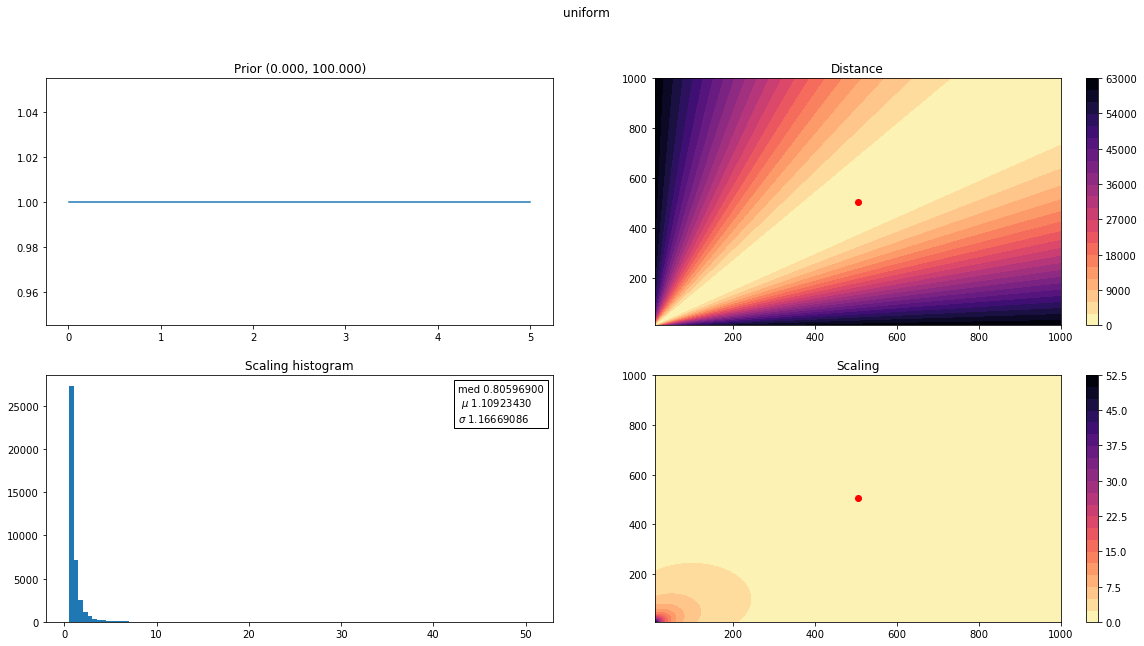

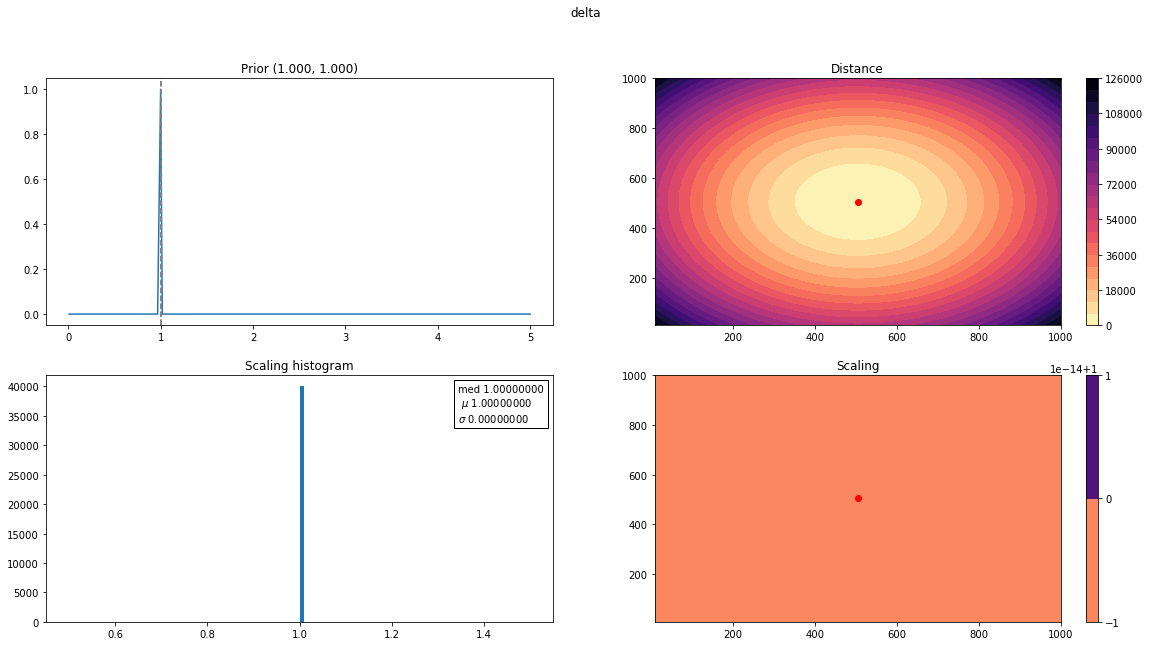

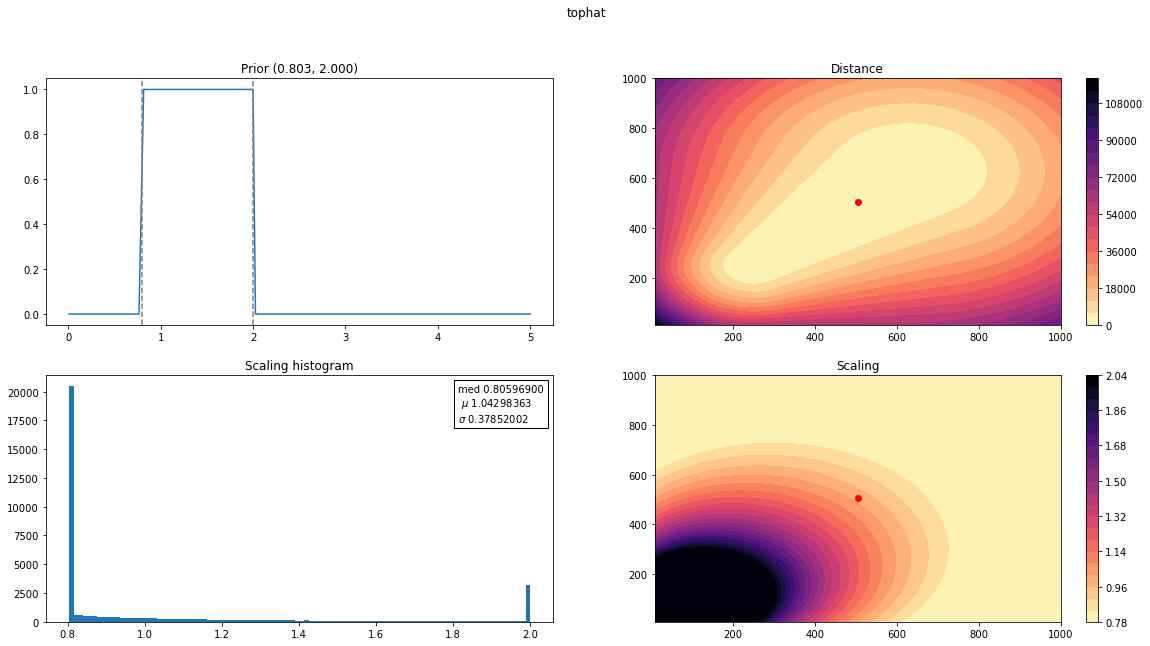

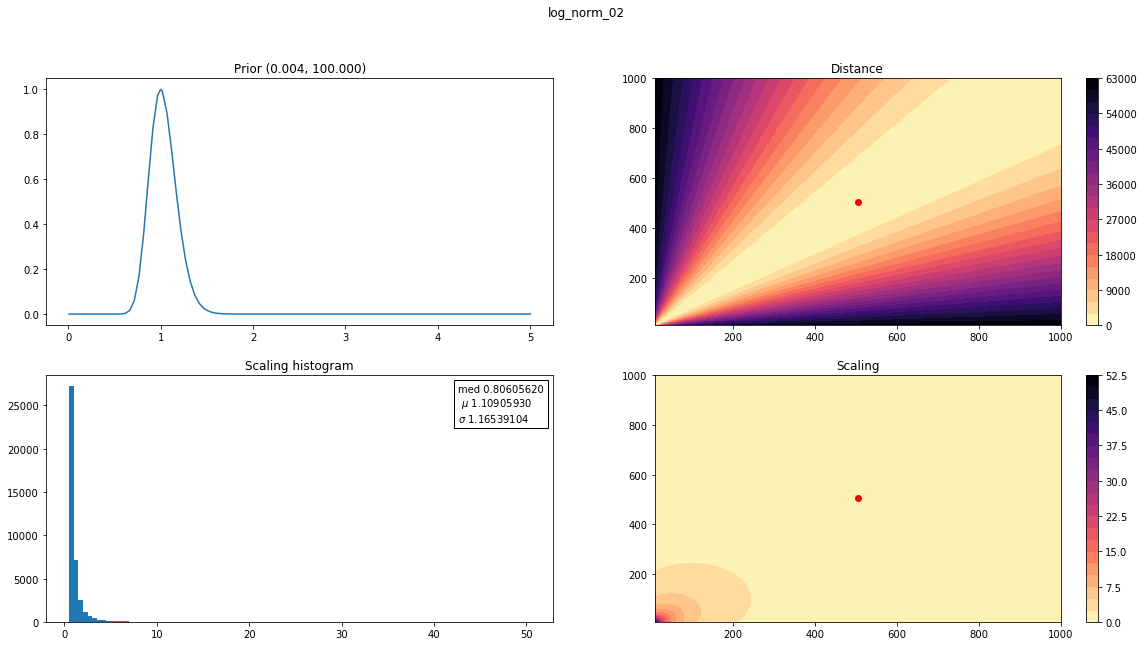

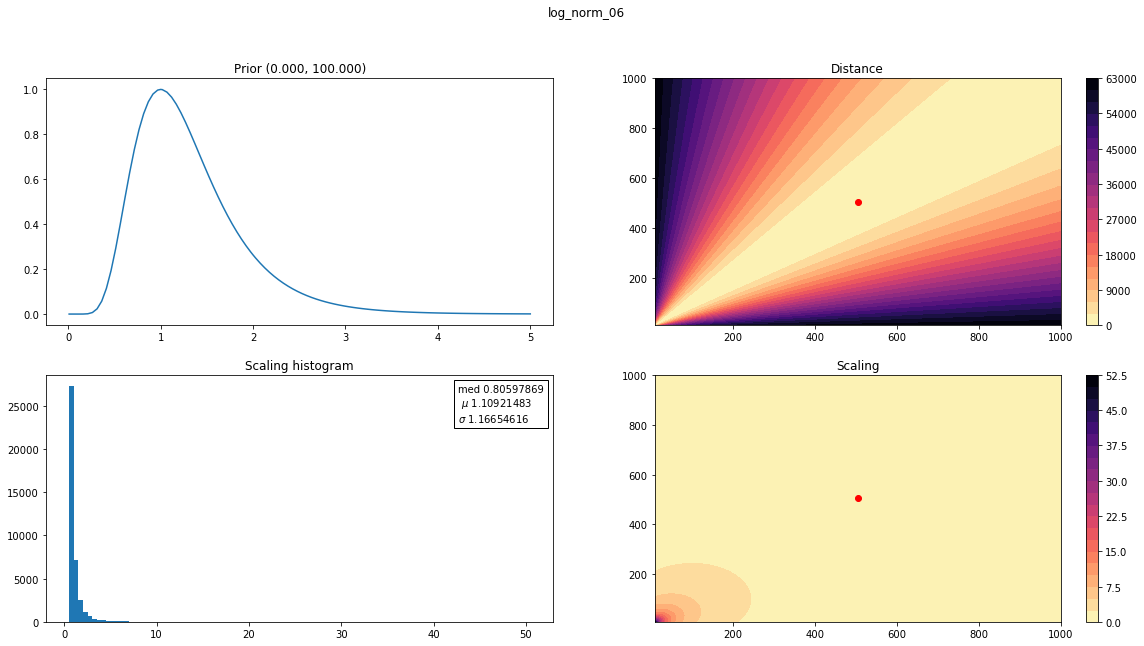

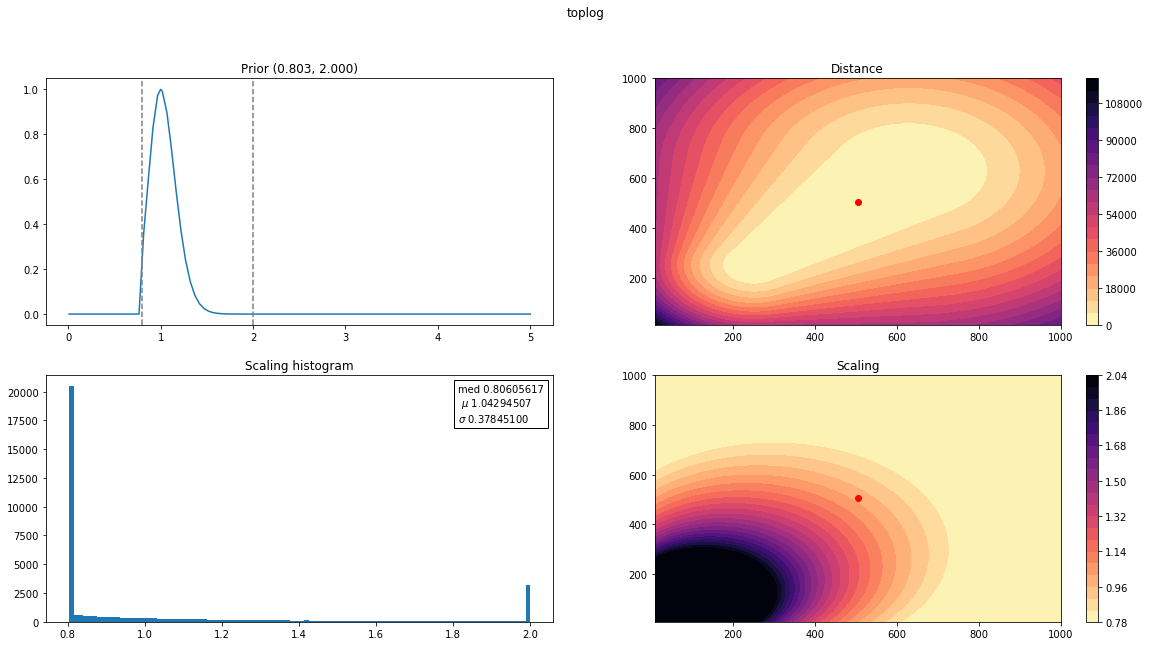

In [16]:
%%timeit -n1 -r1

priors = dict(
    uniform = lambda x: 0 * x + 1,
    delta = lambda x: (x == 1.).astype(np.float),
    tophat = lambda x: np.logical_and(x >= 0.8, x <= 2.).astype(np.float),
    log_norm_02 = lambda x: np.exp(-np.log(x)**2/0.2**2),
    log_norm_06 = lambda x: np.exp(-np.log(x)**2/0.6**2),
)

priors['toplog'] = lambda x: priors['tophat'](x) * priors['log_norm_02'](x)

for title, prior in priors.items():
    fig = plt.figure()
    results[title] = plot_scaled_distance(fig, xcoords, ycoords, center, center_error, Chi2Scaling(prior), title=title)

In [17]:
norm = colors.Normalize()

Text(0.5, 1.0, 'Uniform vs lognorm(0.6)')

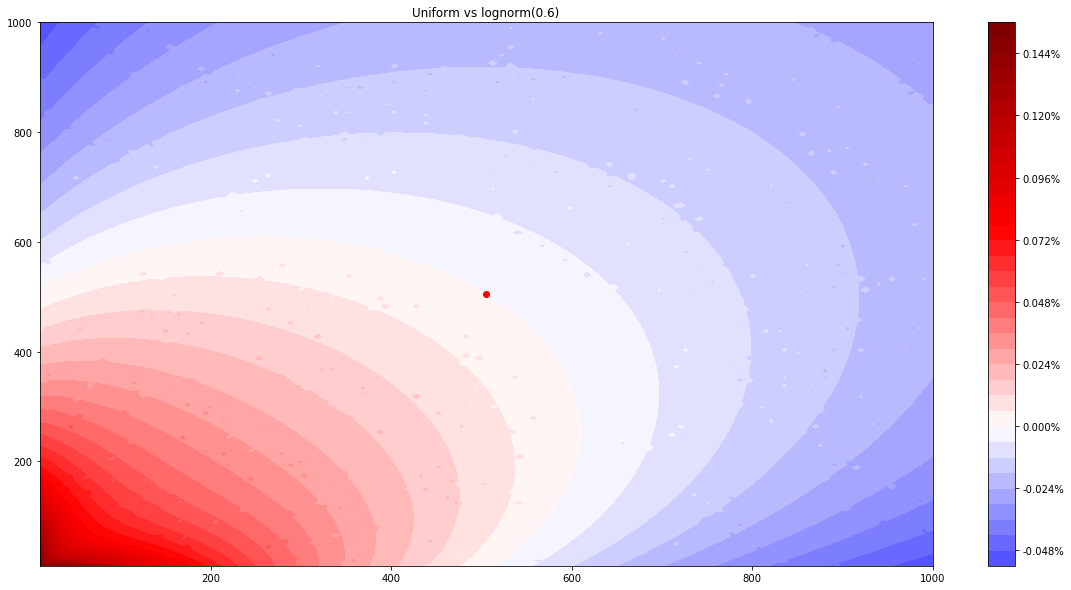

In [18]:
plt.figure()
ratio = (results['uniform'][1] - results['log_norm_02'][1])/results['uniform'][1]*100
r = np.max(np.abs(ratio))
contour = plt.contourf(xcoords, ycoords, ratio, 40, cmap='seismic', vmin=-r, vmax=r, norm=norm)
plt.scatter([xcenter], [ycenter], c='red')
plt.colorbar(contour, format='%.3f%%')
plt.title('Uniform vs lognorm(0.6)')

Text(0.5, 1.0, 'Uniform vs lognorm(0.6)')

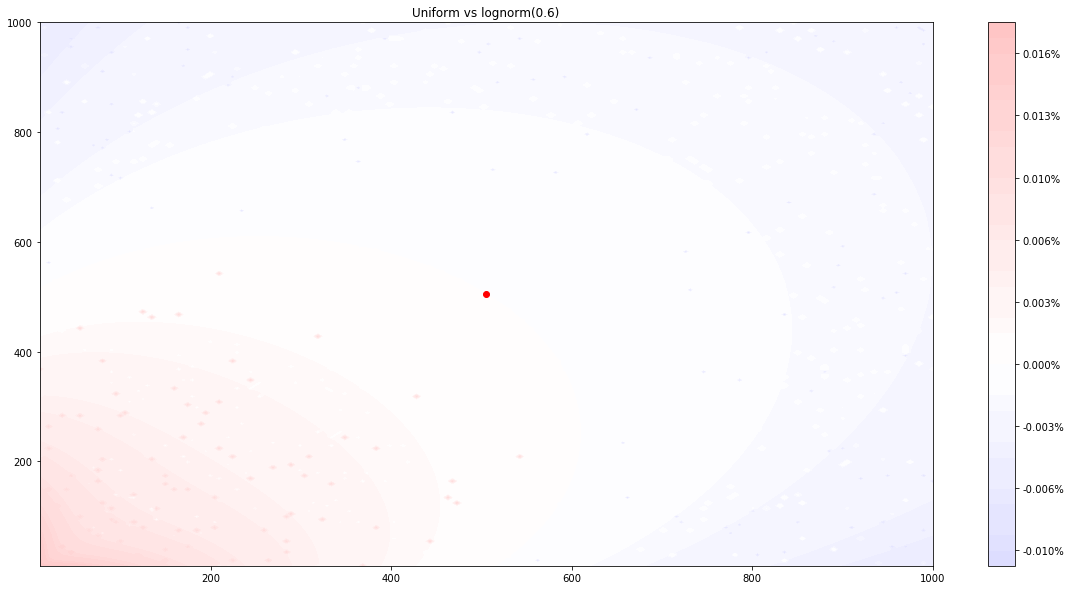

In [19]:
plt.figure()
ratio = (results['uniform'][1] - results['log_norm_06'][1])/results['uniform'][1]*100
r = np.max(np.abs(ratio))
contour = plt.contourf(xcoords, ycoords, ratio, 40, cmap='seismic', norm=norm)
plt.scatter([xcenter], [ycenter], c='red')
plt.colorbar(contour, format='%.3f%%')
plt.title('Uniform vs lognorm(0.6)')